In [2]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [4]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x



In [5]:
# Define the number of users and items in the MovieLens 100K dataset
nb_users = 943
nb_items = 1682

# Instantiate the NeuMF model
mf_dim = 8
mlp_layer_sizes = [16, 8]
dropout = 0.2

model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes, dropout)

# Generate random user and item indices
user_idx = torch.randint(1, nb_users + 1, (1,))
item_idx = torch.randint(1, nb_items + 1, (1,))

# Perform forward pass
output = model(user_idx, item_idx, sigmoid=True)

print("Output:", output.item())


Output: 0.520626962184906


### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [6]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]


### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [7]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 943 + 1
movies_num = 1682 + 1

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets
train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)
model = NeuMF(users_num,movies_num,16,[128,64,32])
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
test_loss = []
train_loss = []
for epoch in range(50):
    model.train()
    tr_loss=[]
    print("Traininng "+str(epoch))
    for (u,i,l) in tqdm.tqdm(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        # calculate loss
        loss = criterion(yhat, l)
        tr_loss.append(loss.detach().numpy())
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
    train_loss.append(np.mean(tr_loss))
    model.eval()
    predictions = []
    with torch.no_grad():
        t_loss=[]
        for i, (u,i,l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid=True)
            predictions.append(yhat)
            l = l.unsqueeze(1)
            tl = criterion(yhat, l)
            t_loss.append(tl) 
        test_loss.append(np.mean(t_loss))

Traininng 0


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 1


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.08it/s]


Traininng 2


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.50it/s]


Traininng 3


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.56it/s]


Traininng 4


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.19it/s]


Traininng 5


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.53it/s]


Traininng 6


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 7


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.25it/s]


Traininng 8


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.47it/s]


Traininng 9


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.27it/s]


Traininng 10


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.35it/s]


Traininng 11


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.65it/s]


Traininng 12


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.17it/s]


Traininng 13


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.10it/s]


Traininng 14


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.71it/s]


Traininng 15


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.16it/s]


Traininng 16


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.45it/s]


Traininng 17


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.30it/s]


Traininng 18


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.47it/s]


Traininng 19


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.33it/s]


Traininng 20


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.19it/s]


Traininng 21


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.00it/s]


Traininng 22


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.26it/s]


Traininng 23


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.57it/s]


Traininng 24


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.55it/s]


Traininng 25


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.22it/s]


Traininng 26


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.26it/s]


Traininng 27


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.24it/s]


Traininng 28


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.66it/s]


Traininng 29


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.64it/s]


Traininng 30


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.29it/s]


Traininng 31


100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.53it/s]


Traininng 32


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 33


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 34


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 35


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 36


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 37


100%|███████████████████████████████████████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 38


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.53it/s]


Traininng 39


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 40


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 41


100%|███████████████████████████████████████████| 15/15 [00:06<00:00,  2.48it/s]


Traininng 42


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 43


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.62it/s]


Traininng 44


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.60it/s]


Traininng 45


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 46


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.62it/s]


Traininng 47


100%|███████████████████████████████████████████| 15/15 [00:07<00:00,  2.12it/s]


Traininng 48


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.56it/s]


Traininng 49


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


### Plot results

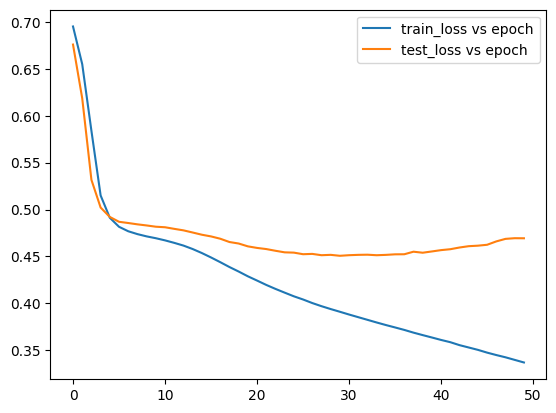

In [8]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()

### Your task
1. Find best HP of the model by crossvalidation
2. for every user provide the recommendation, calculate HR@10 (as in the previous excersise)

In [9]:
#I copied the HR@n code from the other notebook.
def HR_at_n(R,R_hat,R_exclude,n=10):

    #YOUR TASK: implement HR@n function
    R_hat = copy.copy(R_hat)
    exclude_items_per_user = np.sum(R_exclude>0, axis = 1)
    R_hat[R_exclude>0] = -np.inf
    pred_items = np.argsort(-R_hat, axis = 1)
    true_items = np.argsort(-R, axis = 1)
    exclude_items_cnt = np.sum(R_exclude>0, axis = 1)
    test_items_cnt = np.sum(R>0, axis = 1)
    hr_total = 0
    for i in range(pred_items.shape[0]):
        min_end = min(n, pred_items.shape[1]-exclude_items_cnt[i])
        pred_items_user = pred_items[i, :min_end]
        itemscnt_for_user = np.sum(np.in1d(pred_items_user, true_items[i, :test_items_cnt[i]]))
        if test_items_cnt[i]>0:
            hr_for_user = itemscnt_for_user/min(n, test_items_cnt[i])
            hr_total += hr_for_user
    
    hr_total /= np.shape(R)[0]
    return hr_total

In [10]:
import random
import numpy as np
import tqdm
from torch.utils.data import Subset

# Define hyperparameters to search over
mf_dim_list = [8, 16]
mlp_layer_sizes_list = [[64, 32], [128, 64, 32]]
dropout_list = [0.2, 0.4]
lr_list = [0.001, 0.01]

# Define the number of folds for cross-validation
k_folds = 5

best_hr_at_n = 0
best_hyperparams = {}

# Perform cross-validation
for mf_dim in mf_dim_list:
    for mlp_layer_sizes in mlp_layer_sizes_list:
        for dropout in dropout_list:
            for lr in lr_list:
                hr_at_n_scores = []
                random.seed(42)  # Set random seed for reproducibility

                # Initialize the NeuMF model with current hyperparameters
                model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes, dropout)
                criterion = nn.BCELoss()
                optimizer = Adam(model.parameters(), lr=lr)

                # Create indices for cross-validation folds
                indices = list(range(len(ds_train)))
                random.shuffle(indices)
                fold_size = len(ds_train) // k_folds

                # Perform k-fold cross-validation
                for i in range(k_folds):
                    # Split indices into training and validation indices
                    val_indices = indices[i * fold_size: (i + 1) * fold_size]
                    train_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]

                    # Create data loaders for training and validation
                    train_ds = Subset(ds_train, train_indices)
                    val_ds = Subset(ds_train, val_indices)

                    train_dl = DataLoader(train_ds, batch_size=16*1024, shuffle=True)
                    val_dl = DataLoader(val_ds, batch_size=16*1024, shuffle=False)

                    # Train the model
                    model.train()
                    tr_loss = []
                    for (u, i, l) in tqdm.tqdm(train_dl):
                        # Clear the gradients
                        optimizer.zero_grad()
                        # Compute the model output
                        yhat = model(u, i, sigmoid=True)
                        l = l.unsqueeze(1)
                        # Calculate loss
                        loss = criterion(yhat, l)
                        tr_loss.append(loss.detach().numpy())
                        # Credit assignment
                        loss.backward()
                        # Update model weights
                        optimizer.step()

                    train_loss = np.mean(tr_loss)

                    # Evaluate the model on the validation set
                    model.eval()
                    predictions = []
                    with torch.no_grad():
                        t_loss = []
                        for (u, i, l) in val_dl:
                            yhat = model(u, i, sigmoid=True)
                            predictions.append(yhat)
                            l = l.unsqueeze(1)
                            tl = criterion(yhat, l)
                            t_loss.append(tl)

                    test_loss = np.mean(t_loss)

                    # Calculate HR@n metric using the HR_at_n function
                    hr_at_n = HR_at_n(ds_train.get_ratings_matrix(), predictions, ds_train.get_exclude_matrix(), n=10)
                    hr_at_n_scores.append(hr_at_n)

                # Calculate average HR@n across all folds
                avg_hr_at_n = np.mean(hr_at_n_scores)

                # Check if the current hyperparameters yield a better HR@n score
                if avg_hr_at_n > best_hr_at_n:
                    best_hr_at_n = avg_hr_at_n
                    best_hyperparams = {
                        'mf_dim': mf_dim,
                        'mlp_layer_sizes': mlp_layer_sizes,
                        'dropout': dropout,
                        'lr': lr
                    }

# Print the best hyperparameters and corresponding HR@n score
print("Best Hyperparameters:")
print(best_hyperparams)
print("Best HR@n Score:", best_hr_at_n)


100%|███████████████████████████████████████████| 12/12 [00:04<00:00,  2.76it/s]


AttributeError: 'ML100kDataset' object has no attribute 'get_ratings_matrix'